# 1-4,时间序列数据建模流程范例
国内的新冠肺炎疫情从发现至今已经持续3个多月了，这场起源于吃野味的灾难给大家的生活造成了诸多方面的影响。

有的同学是收入上的，有的同学是感情上的，有的同学是心理上的，还有的同学是体重上的。

那么国内的新冠肺炎疫情何时结束呢？什么时候我们才可以重获自由呢？

本篇文章将利用TensorFlow2.0建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测。

## 一，准备数据
本文的数据集取自tushare，获取该数据集的方法参考了以下文章。

《https://zhuanlan.zhihu.com/p/109556102》

![Image Name](https://cdn.kesci.com/upload/image/q9e4myhn4a.png)


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(-10.0, 0, '2020-03-01'),
  Text(0.0, 0, '2020-01-24'),
  Text(10.0, 0, '2020-02-03'),
  Text(20.0, 0, '2020-02-13'),
  Text(30.0, 0, '2020-02-23'),
  Text(40.0, 0, '2020-03-04'),
  Text(50.0, 0, '')])

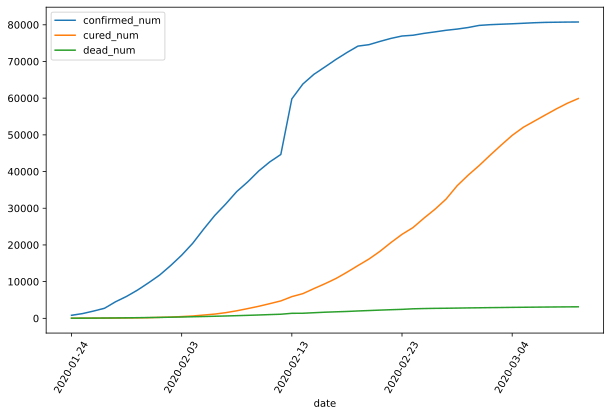

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("../data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)

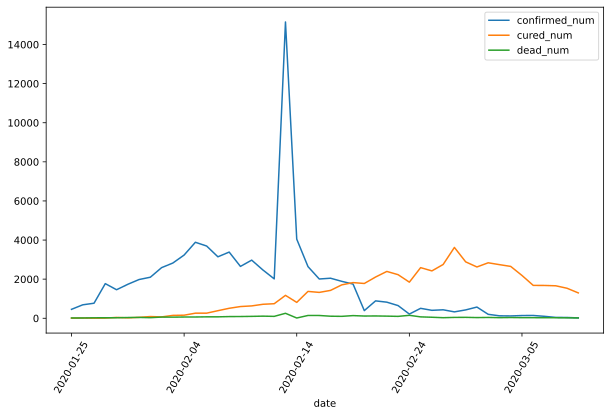

In [3]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [4]:
#用某日前8天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#数据较小，可以将全部训练数据放入到一个batch中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

## 二，定义模型
使用Keras接口有以下3种方式构建模型：使用Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型。

此处选择使用函数式API构建任意结构模型。

In [5]:
#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config

In [6]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, None, 3)      84          ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, None, 3)      84          ['lstm[0][0]']                   
                                                                                                  
 lstm_2 (LSTM)                  (None, None, 3)      84          ['lstm_1[0][0]']                 
                                                                                              

## 三，训练模型
训练模型通常有3种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也最简单的内置fit方法。

注：循环神经网络调试较为困难，需要设置多个不同的学习率多次尝试，以取得较好的效果。

In [7]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config

In [8]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

Epoch 1/500
1/1 [==============================] - 4s 4s/step - loss: 3.3679 - lr: 0.0100
Epoch 2/500
1/1 [==============================] - 0s 86ms/step - loss: 3.1369 - lr: 0.0100
Epoch 3/500
1/1 [==============================] - 0s 52ms/step - loss: 2.9000 - lr: 0.0100
Epoch 4/500
1/1 [==============================] - 0s 74ms/step - loss: 2.6494 - lr: 0.0100
Epoch 5/500
1/1 [==============================] - 0s 70ms/step - loss: 2.3839 - lr: 0.0100
Epoch 6/500
1/1 [==============================] - 0s 55ms/step - loss: 2.1041 - lr: 0.0100
Epoch 7/500
1/1 [==============================] - 0s 76ms/step - loss: 1.8122 - lr: 0.0100
Epoch 8/500
1/1 [==============================] - 0s 70ms/step - loss: 1.5150 - lr: 0.0100
Epoch 9/500
1/1 [==============================] - 0s 64ms/step - loss: 1.2212 - lr: 0.0100
Epoch 10/500
1/1 [==============================] - 0s 70ms/step - loss: 0.9447 - lr: 0.0100
Epoch 11/500
1/1 [==============================] - 0s 76ms/step - loss: 0.7034 -

1/1 [==============================] - 0s 43ms/step - loss: 0.4455 - lr: 0.0100
Epoch 90/500
1/1 [==============================] - 0s 67ms/step - loss: 0.4455 - lr: 0.0100
Epoch 91/500
1/1 [==============================] - 0s 63ms/step - loss: 0.4454 - lr: 0.0100
Epoch 92/500
1/1 [==============================] - 0s 75ms/step - loss: 0.4454 - lr: 0.0100
Epoch 93/500
1/1 [==============================] - 0s 51ms/step - loss: 0.4454 - lr: 0.0100
Epoch 94/500
1/1 [==============================] - 0s 69ms/step - loss: 0.4454 - lr: 0.0100
Epoch 95/500
1/1 [==============================] - 0s 61ms/step - loss: 0.4453 - lr: 0.0100
Epoch 96/500
1/1 [==============================] - 0s 64ms/step - loss: 0.4453 - lr: 0.0100
Epoch 97/500
1/1 [==============================] - 0s 52ms/step - loss: 0.4453 - lr: 0.0100
Epoch 98/500
1/1 [==============================] - 0s 67ms/step - loss: 0.4453 - lr: 0.0100
Epoch 99/500
1/1 [==============================] - 0s 67ms/step - loss: 0.4453 - l

1/1 [==============================] - 0s 47ms/step - loss: 0.4368 - lr: 0.0050
Epoch 177/500
1/1 [==============================] - 0s 39ms/step - loss: 0.4348 - lr: 0.0050
Epoch 178/500
1/1 [==============================] - 0s 39ms/step - loss: 0.4328 - lr: 0.0050
Epoch 179/500
1/1 [==============================] - 0s 55ms/step - loss: 0.4310 - lr: 0.0050
Epoch 180/500
1/1 [==============================] - 0s 64ms/step - loss: 0.4295 - lr: 0.0050
Epoch 181/500
1/1 [==============================] - 0s 78ms/step - loss: 0.4283 - lr: 0.0050
Epoch 182/500
1/1 [==============================] - 0s 68ms/step - loss: 0.4274 - lr: 0.0050
Epoch 183/500
1/1 [==============================] - 0s 59ms/step - loss: 0.4268 - lr: 0.0050
Epoch 184/500
1/1 [==============================] - 0s 83ms/step - loss: 0.4254 - lr: 0.0050
Epoch 185/500
1/1 [==============================] - 0s 56ms/step - loss: 0.4242 - lr: 0.0050
Epoch 186/500
1/1 [==============================] - 0s 77ms/step - loss: 

## 四，评估模型
评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

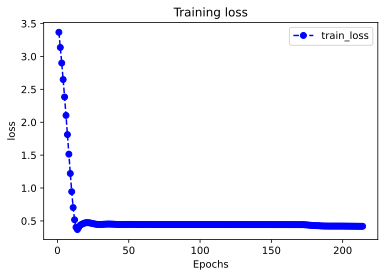

In [10]:
plot_metric(history,"loss")

## 五，使用模型
此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。

In [11]:
#使用dfresult记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()


,confirmed_num,cured_num,dead_num
41,143.0,1681.0,30.0
42,99.0,1678.0,28.0
43,44.0,1661.0,27.0
44,40.0,1535.0,22.0
45,19.0,1297.0,17.0


In [12]:
#预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [13]:
dfresult.query("confirmed_num==0").head()

# 第55天开始新增确诊降为0，第45天对应3月10日，也就是10天后，即预计3月20日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
52,0.0,1856.0,0.0
53,0.0,1926.0,0.0
54,0.0,1992.0,0.0
55,0.0,2058.0,0.0
56,0.0,2128.0,0.0


In [14]:
dfresult.query("cured_num==0").head()

# 第164天开始新增治愈降为0，第45天对应3月10日，也就是大概4个月后，即7月10日左右全部治愈。
# 注: 该预测偏悲观，并且存在问题，如果将每天新增治愈人数加起来，将超过累计确诊人数。

,confirmed_num,cured_num,dead_num


In [15]:
dfresult.query("dead_num==0").head()

# 第60天开始，新增死亡降为0，第45天对应3月10日，也就是大概15天后，即20200325
# 该预测较为合理

,confirmed_num,cured_num,dead_num
47,8.0,1433.0,0.0
48,5.0,1517.0,0.0
49,3.0,1606.0,0.0
50,2.0,1695.0,0.0
51,1.0,1779.0,0.0


## 六，保存模型
推荐使用TensorFlow原生方式保存模型。

In [16]:
model.save('../data/tf_model_savedmodel', save_format="tf")
print('export saved model.')

INFO:tensorflow:Assets written to: ../data/tf_model_savedmodel\assets


INFO:tensorflow:Assets written to: ../data/tf_model_savedmodel\assets


export saved model.


In [17]:
model_loaded = tf.keras.models.load_model('../data/tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

array([[1107.091   ,   87.78725 ,    0.      ],
       [1365.5353  ,   68.83318 ,    0.      ],
       [1490.0105  ,  146.6446  ,    0.      ],
       [1705.2048  ,  156.62044 ,    0.      ],
       [2049.6216  ,  259.37143 ,    0.      ],
       [1948.3535  ,  260.369   ,    0.      ],
       [1657.7355  ,  386.0644  ,    0.      ],
       [1785.3754  ,  508.767   ,    0.      ],
       [1398.7638  ,  597.5518  ,    0.      ],
       [1568.0712  ,  630.47205 ,    0.      ],
       [1301.1879  ,  713.2714  ,    0.      ],
       [1062.7863  ,  742.2013  ,    0.      ],
       [7991.203   , 1168.169   ,    0.      ],
       [2134.5388  ,  810.03687 ,    0.      ],
       [1392.962   , 1369.6805  ,    0.      ],
       [1059.0941  , 1319.8015  ,    0.      ],
       [1080.1917  , 1421.5549  ,    0.      ],
       [ 957.5542  , 1693.2931  ,    0.      ],
       [ 826.6462  , 1785.8446  ,    0.      ],
       [ 172.26726 , 1718.0879  ,    0.      ],
       [ 375.5648  , 2015.9624  ,    0. 